In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Force CPU before importing JAX

import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
from diffrax import diffeqsolve, Dopri5, SaveAt, ODETerm

# --- Model definition (must match training) ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key):
        self.mlp = eqx.nn.MLP(in_size=265, out_size=262, width_size=512, depth=4, key=key)

    def __call__(self, P, H, rho, z):
        x = jnp.concatenate([P, H, rho, z])
        return self.mlp(x)

# --- Paths ---
z_idx = 0
model_file = f"/srv/scratch2/taylor.4264/odd_emu/production_models/learned_model_rhom_zchunk_{z_idx:02d}.eqx"
parent_dir = "/srv/scratch2/taylor.4264/odd_emu/production_run/merged/"

# --- Load model ---
model_template = RHS(jax.random.PRNGKey(0))
model = eqx.tree_deserialise_leaves(model_file, model_template)

# --- Load data ---
z_grid = jnp.load(os.path.join(parent_dir, f"z_{z_idx}.npy"))
Hz_full = jnp.load(os.path.join(parent_dir, f"Hz_{z_idx}.npy")).astype(jnp.float32)
rho_m_full = jnp.load(os.path.join(parent_dir, f"rho_m_{z_idx}.npy")).astype(jnp.float32)

# --- Normalization of H(z) ---
H_flat = Hz_full.reshape(-1)
H_mean = jnp.mean(H_flat)
H_std = jnp.std(H_flat)
Hz = (Hz_full[0] - H_mean) / H_std

# --- Normalization of log10(rho_m) ---
log_rho_flat = jnp.log10(rho_m_full.reshape(-1) + 1e-30)
log_rho_mean = jnp.mean(log_rho_flat)
log_rho_std = jnp.std(log_rho_flat)
log_rho_m = (jnp.log10(rho_m_full[0] + 1e-30) - log_rho_mean) / log_rho_std

# --- Flip redshift for forward integration ---
z_grid = z_grid[::-1]
Hz = Hz[::-1]
log_rho_m = log_rho_m[::-1]

# --- Interpolators ---
def H_fn(z):
    return jnp.interp(z, z_grid, Hz)

def rhom_fn(z):
    return jnp.interp(z, z_grid, log_rho_m)

# --- Initial condition (lowest redshift, i.e., highest index) ---
pk0 = jnp.load(os.path.join(parent_dir, f"pk_nl_{z_idx}.npy"))[0, -1]
y0 = jnp.log1p(pk0)

# --- Define RHS for ODE integration ---
def rhs(t, y, args):
    model, H_fn, rhom_fn = args
    H = H_fn(t)
    rho = rhom_fn(t)
    z = jnp.array([t])
    return model(y, jnp.array([H]), jnp.array([rho]), z)

# --- Setup ODE solver ---
term = ODETerm(rhs)
solver = Dopri5()
saveat = SaveAt(ts=z_grid)

print("Initial z:", float(z_grid[0]))
print("Final z:", float(z_grid[-1]))
print("H(z) range:", H_fn(z_grid).min(), H_fn(z_grid).max())
print("rho_m(z) range:", rhom_fn(z_grid).min(), rhom_fn(z_grid).max())
print("log(1+P(k)) range:", y0.min(), y0.max())

# --- Solve the ODE ---
sol = diffeqsolve(
    term,
    solver,
    t0=float(z_grid[0]),
    t1=float(z_grid[-1]),
    dt0=-1e-2,
    y0=y0,
    args=(model, H_fn, rhom_fn),
    saveat=saveat
)

# --- Output ---
Pk_pred = jnp.expm1(sol.ys)
print("Shape of predicted P(k,z):", Pk_pred.shape)

Initial z: 0.05000000074505806
Final z: 0.0
H(z) range: -1.7926967 -1.393064
rho_m(z) range: -1.6836302 -1.5058672
log(1+P(k)) range: 3.3267946 11.571705
Shape of predicted P(k,z): (100, 262)


Text(0.5, 1.0, 'z=0.05')

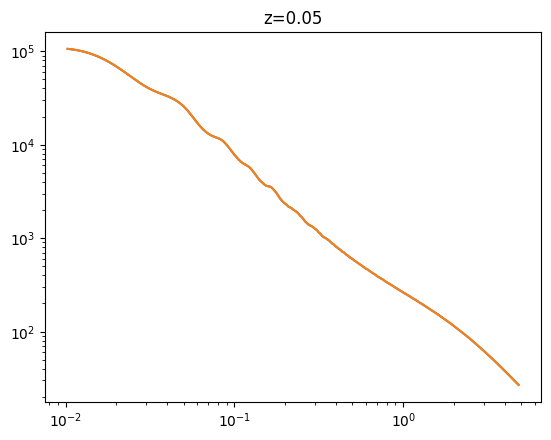

In [22]:
parent_dir = "/srv/scratch2/taylor.4264/odd_emu/production_run/merged"
k = np.load(parent_dir + "/k_0.npy")  # (262,)'')

from matplotlib import pyplot as plt
plt.plot(k, Pk_pred[0])
plt.plot(k, pk0)
plt.xscale('log')
plt.yscale('log')
plt.title('z=0.05')


Text(0.5, 1.0, 'z=0.0')

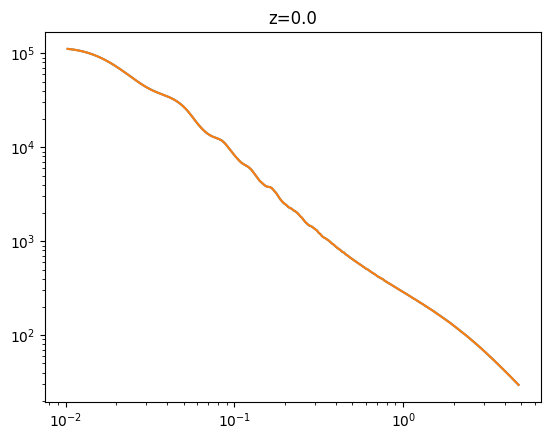

In [19]:
plt.plot(k, Pk_pred[99])
pk_all = jnp.load(os.path.join(parent_dir, f"pk_nl_{z_idx}.npy"))
plt.plot(k, pk_all[0, 0])
plt.xscale('log')
plt.yscale('log')
plt.title('z=0.0')

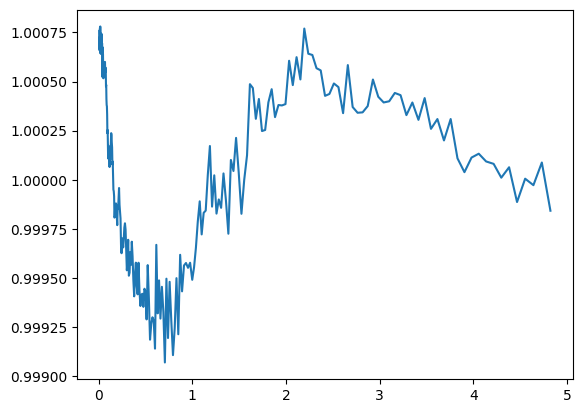

In [20]:
plt.plot(k, Pk_pred[99] / pk_all[0,0])